# Mountaincar Environment
* Eval can start anywhere from left to goal state, vel 0 (also training). They need 71 episodes
* Modify cartpole to only have two actions-> left and right. The magnitude of the actions are much larger in nfq paper
* Hint to goal, which sometimes makes the agent perform worse
* Group: the magnitude of the action
* Made the forces symmetric

In [1]:
import configargparse
import torch
import torch.optim as optim
import sys
sys.path.append('../')

from environments import MountainCarEnv, Continuous_MountainCarEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import tqdm

# Running experiments

## "Structureless Test"
* The dynamics of the systems are actually the same. Do any of the algorithms learn a difference?

0


  0%|          | 1/1501 [00:00<11:04,  2.26it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


  0%|          | 6/1501 [00:02<09:03,  2.75it/s]


FREEZING SHARED
FG Trained
Evaluation bg: 100.0 Evaluation fg: 100.0
1


  0%|          | 1/1501 [00:01<33:23,  1.34s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  2%|▏         | 36/1501 [00:13<09:01,  2.71it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 52.0 Evaluation fg: 60.0
2


  0%|          | 1/1501 [00:00<11:58,  2.09it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


 33%|███▎      | 501/1501 [03:04<10:12,  1.63it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 67%|██████▋   | 1001/1501 [06:07<05:22,  1.55it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 74%|███████▍  | 1113/1501 [06:47<02:22,  2.73it/s]


FREEZING SHARED
FG Trained
Evaluation bg: 100.0 Evaluation fg: 100.0
3


  0%|          | 1/1501 [00:01<32:55,  1.32s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  0%|          | 5/1501 [00:02<13:29,  1.85it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
4


  0%|          | 1/1501 [00:01<31:31,  1.26s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 33%|███▎      | 501/1501 [03:03<10:22,  1.61it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 67%|██████▋   | 1001/1501 [06:05<05:22,  1.55it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [09:12<00:00,  2.72it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0
5


  0%|          | 1/1501 [00:01<35:52,  1.43s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  5%|▌         | 79/1501 [00:31<09:33,  2.48it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
6


  0%|          | 1/1501 [00:01<32:56,  1.32s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  1%|          | 16/1501 [00:07<11:08,  2.22it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
7


  0%|          | 1/1501 [00:01<34:50,  1.39s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 33%|███▎      | 501/1501 [05:55<21:32,  1.29s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 67%|██████▋   | 1001/1501 [12:00<05:28,  1.52it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [16:03<00:00,  1.56it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0
8


  0%|          | 1/1501 [00:01<30:14,  1.21s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  0%|          | 4/1501 [00:02<14:09,  1.76it/s]


FREEZING SHARED
FG Trained
Evaluation bg: 100.0 Evaluation fg: 100.0
9


  0%|          | 2/1501 [00:01<24:12,  1.03it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 13%|█▎        | 189/1501 [01:09<08:02,  2.72it/s]


FREEZING SHARED
FG Trained
Evaluation bg: 100.0 Evaluation fg: 100.0
10


  0%|          | 1/1501 [00:01<30:48,  1.23s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  5%|▍         | 72/1501 [00:26<08:52,  2.69it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
11


  0%|          | 1/1501 [00:01<32:47,  1.31s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  1%|          | 10/1501 [00:04<11:20,  2.19it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
12


  0%|          | 1/1501 [00:00<09:38,  2.59it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


  2%|▏         | 27/1501 [00:09<06:54,  3.55it/s]

FREEZING SHARED


  2%|▏         | 27/1501 [00:09<08:39,  2.84it/s]

FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
13


  0%|          | 1/1501 [00:00<09:08,  2.74it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


  0%|          | 2/1501 [00:00<09:59,  2.50it/s]


FREEZING SHARED
FG Trained
Evaluation bg: 100.0 Evaluation fg: 100.0
14


  0%|          | 1/1501 [00:01<31:54,  1.28s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 33%|███▎      | 501/1501 [03:09<11:13,  1.48it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 67%|██████▋   | 1001/1501 [06:15<05:09,  1.61it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [09:19<00:00,  2.68it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0


/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Dynamics are the same in fg and bg environments')

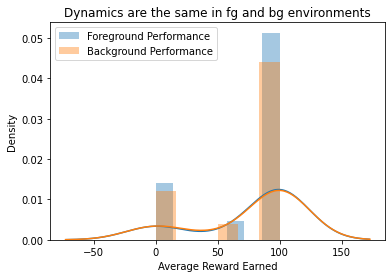

In [2]:
import json
from train_mountaincar import fqi, warm_start, transfer_learning
num_iter=15
perf_foreground = []
perf_background = []
for i in range(num_iter):
    print(str(i))
    perf_bg, perf_fg = fqi(epoch=1500, gravity=0.0025, verbose=True, is_contrastive=True, structureless=True, hint_to_goal=False)
    perf_foreground.append(perf_fg)
    perf_background.append(perf_bg)
sns.distplot(perf_foreground, label='Foreground Performance')
sns.distplot(perf_background, label='Background Performance')
plt.legend()
plt.xlabel("Average Reward Earned")
plt.title("Dynamics are the same in fg and bg environments")

## "Performance when force left is different"
* We change the gravity on the foreground environments. 